# Literature Sources for the Equations

[WSL Swiss Federal Institute for Forest, Snow, and Landscape Research Fire Weather Indices Wiki](https://wikifire.wsl.ch/tiki-index908f.html?page=Keetch-Byram+drought+index#:~:text=Formula,Keetch%20and%20Byram%20(1968).)

[Alexander, 1990: Computer calculation of the Keetch-Byram drought index - programmers beware](https://people.atmos.ucla.edu/ycao/papers/Computer%20Calculation%20of%20the%20Keetch-Byram%20Drought%20Index-Programmers%20Beware!.pdf)

[Keetch and Byram, 1968: A drought index for forest fire control, USDA FSRP SE-38](https://research.fs.usda.gov/treesearch/40)

[Wildland Fire Assessment System](https://www.wfas.net/index.php?option=com_content&view=article&id=86&Itemid=487#:~:text=Keetch%20and%20Byram%20(1968)%20designed,duff%20and%20upper%20soil%20layers.)

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from more_itertools import consecutive_groups

import dask
import dask.array as da

import matplotlib.pyplot as plt

In [3]:
# file paths
# pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

pr_file = r'C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

In [4]:
# parallelization
# chunks = {'time':-1,'lat':50,'lon':50}

# Steps (starting with single cell calculation)

1) KBDI initialization: find the starting day of the calculation
    - find when the running sum of precip over a 1 week period is at least 152mm (6 inches)
    - the starting day for calculating KBDI is the next day
2) calculate the number of consecutive days with rain (rr) for the whole timeseries so we can accurately calculate Pnet
3) calculate Pnet at each time using the description in Keetch and Byram
4) calculate Q of t0 using KBDI of t-1 = 0
5) calculate KBDI

# 1) KBDI Initialization date

Finding the first possible day at each grid where we can set the initial value of KBDI to zero. This requires a preceding wet period where at least 152mm/6inches of precip falls with 1 week.

In [5]:
# load 5 years of precip data at a single grid, limit precision per metadata, and convert units

year_start='1951'
year_end='2024'
lat = 32
lon = -90

pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

pr = pr / 25.4
pr_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
pr.attrs = pr_attrs

pr

<xarray.DataArray 'prcp' (time: 26907)> Size: 108kB
array([0.        , 0.3043307 , 0.9775591 , ..., 0.08149606, 0.23700787,
       0.24566929], shape=(26907,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
Attributes:
    standard_name:  precipitation
    long_name:      Precipitation, daily total
    units:          inches/day

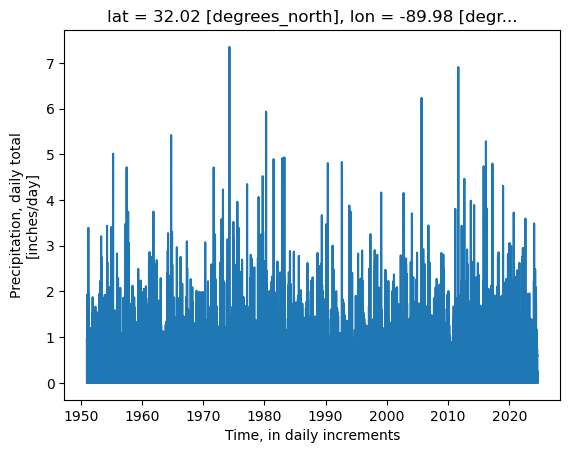

In [6]:
# pr.prcp.sel(time='2015-01-01').plot()
pr.plot()

In [7]:
# determine if the grid is land or water

landmask=1 if np.isfinite(pr.mean()) else 0
landmask

1

In [8]:
# create an integer time index coordinate since datetimes will give us some trouble

time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)

pr

<xarray.DataArray 'prcp' (time: 26907)> Size: 108kB
array([0.        , 0.3043307 , 0.9775591 , ..., 0.08149606, 0.23700787,
       0.24566929], shape=(26907,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 215kB 0 1 2 3 4 ... 26902 26903 26904 26905 26906
Attributes:
    standard_name:  precipitation
    long_name:      Precipitation, daily total
    units:          inches/day

In [9]:
# sum precip in 7 day rolling windows

ndays=7
pr_thresh=8 # inches

pr_weeksum=pr.rolling(time=ndays,min_periods=ndays,center=False).sum()
print(pr_weeksum[0:10].data)
pr_weeksum

[      nan       nan       nan       nan       nan       nan 2.7980316
 2.7980316 2.493701  1.5960631]


<xarray.DataArray 'prcp' (time: 26907)> Size: 108kB
array([       nan,        nan,        nan, ..., 0.08149876, 0.31850663,
       0.5641759 ], shape=(26907,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 215kB 0 1 2 3 4 ... 26902 26903 26904 26905 26906
Attributes:
    standard_name:  precipitation
    long_name:      Precipitation, daily total
    units:          inches/day

In [10]:
# when is the first 7 day sum over the threshold
print(pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time.data)

# what is the max 7 day sum
print(pr_weeksum.max('time').item())

# how many times does the 7 day sum exceed 8
print((pr_weeksum>8).data.sum())

1955-04-13T00:00:00.000000000
10.297247886657715
46


In [11]:
# get the first index time where the weekly sum meets the threshold
# this is index t-1 for the KBDI calc where we'll set it to 0

# day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
day_int

1563

# 2) rr, number of consecutive days with rain

In [12]:
# 1/0 rain/no rain mask
rainmask=xr.where(pr>0,1,0)
rainmask

<xarray.DataArray 'prcp' (time: 26907)> Size: 215kB
array([0, 1, 1, ..., 1, 1, 1], shape=(26907,))
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 215kB 0 1 2 3 4 ... 26902 26903 26904 26905 26906

In [1]:
# calculate number of consecutive rain days at each time step
# I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray

rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
rr

NameError: name 'rainmask' is not defined

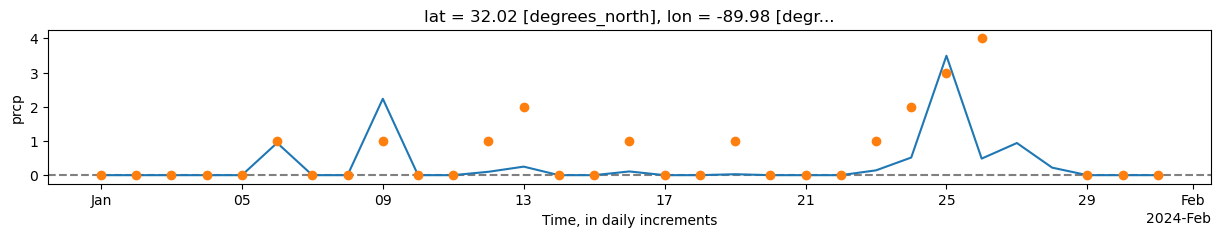

In [14]:
# let's see if it's really working
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey',ls='dashed')  # threshold guide line
plt.ylim([-.25,4.25])
# pr.sel(time=slice('1951-01-01','1951-01-31')).plot()
# rr.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)
pr.sel(time=slice('2024-01-01','2024-01-31')).plot()
rr.sel(time=slice('2024-01-01','2024-01-31')).plot(marker='o',linewidth=0)

wow, ok it is working. blue line is daily precip, orange dots are the number of consecutive rain days.


# 3) Pnet

Approach based on Keetch & Byram 1968 description of Pnet calculation on their worksheet:

1) Categorize days: consecutive rain days (2), single rain days (1), no rain days (0)
2) Calculate Pnet on each day based on the category
    - category 0 (no rain): pnet = 0
    - category 1 (single rain day): pnet = max(pr - 0.2,0)  
    - category 2 (consecutive rain day): loop through events of consecutive rainfall days and
      
            - accumulate rainfall totals over consecutive days
            - on days before threshold is met (accumulated pr <= 0.2 inches): pnet = 0
            - on the exact day when the threshold is met: pnet = accumulated pr - 0.2 inches
            - on days after threshold is met: pnet = pr 

In [15]:
# categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)

# first swap out the time coordinate for the time_index
rr_swap = rr.swap_dims({'time':'time_index'})

# label all days that are at least the 3rd consecutive rainfall day with a 5
cat=xr.where(rr_swap>=3,5,rr_swap)

# find the indexes of all second consecutive rainfall days
consec_day2 = np.argwhere(rr_swap.data==2).flatten()

# find the indexes of all the first consecutive rainfall days
consec_day1 = consec_day2-1

# label all consecutive rainfall days with a 2 
cat[consec_day2]=5 # first put a 5
cat[consec_day1]=5 # first put a 5
cat = xr.where(cat==5,2,cat) # convert to 2's

# should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
np.unique(cat)

array([0., 1., 2.])

In [16]:
np.where(rr_swap.data==2)[0]

array([    2,    10,    29, ..., 26863, 26891, 26905], shape=(2073,))

In [17]:
# Calc Pnet 

acc_thresh = 0.2 # inches

# Category 0 (no rain days)
# pnet will be zero where pr is zero
pnet = pr.swap_dims({'time':'time_index'})

# Category 1 (single rain days)
pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
pnet = xr.where(pnet<0,0,pnet)
pnet

<xarray.DataArray 'prcp' (time_index: 26907)> Size: 108kB
array([0.        , 0.3043307 , 0.9775591 , ..., 0.08149606, 0.23700787,
       0.24566929], shape=(26907,), dtype=float32)
Coordinates:
    time         (time_index) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
  * time_index   (time_index) int64 215kB 0 1 2 3 4 ... 26903 26904 26905 26906

In [18]:
# Category 2 (consecutive rain days) 

consec_inds = cat[cat==2].time_index

# initializations
thresh_flag=False
end_event=False
accpr=0. 

# loop through days in each multi-day rain event
for i,ind in enumerate(consec_inds):
    
    # accumulated precip per rain event
    accpr=accpr+pr[ind].item() 

    # if not over the threshold yet, Pnet is 0
    if accpr<=acc_thresh and not thresh_flag:
        pnet[ind]=0
        
    # on the day the threshold is met, subtract the threshold amount and change flag    
    elif accpr>acc_thresh and not thresh_flag:
        accpr=accpr-acc_thresh # accumulate precip and subtract threshold
        pnet[ind]=accpr
        thresh_flag=True
        
    # any days after the threshold is met, precip will remain unchanged
    else:
        pnet[ind]=pr[ind].item()     

    # reset accumulation and flag for the next consecutive rain event
    if i != len(consec_inds)-1:
        if (consec_inds[i+1] != consec_inds[i]+1): 
            accpr=0.
            thresh_flag=False
            
pnet

<xarray.DataArray 'prcp' (time_index: 26907)> Size: 108kB
array([0.        , 0.1043307 , 0.9775591 , ..., 0.        , 0.11850393,
       0.24566929], shape=(26907,), dtype=float32)
Coordinates:
    time         (time_index) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
  * time_index   (time_index) int64 215kB 0 1 2 3 4 ... 26903 26904 26905 26906

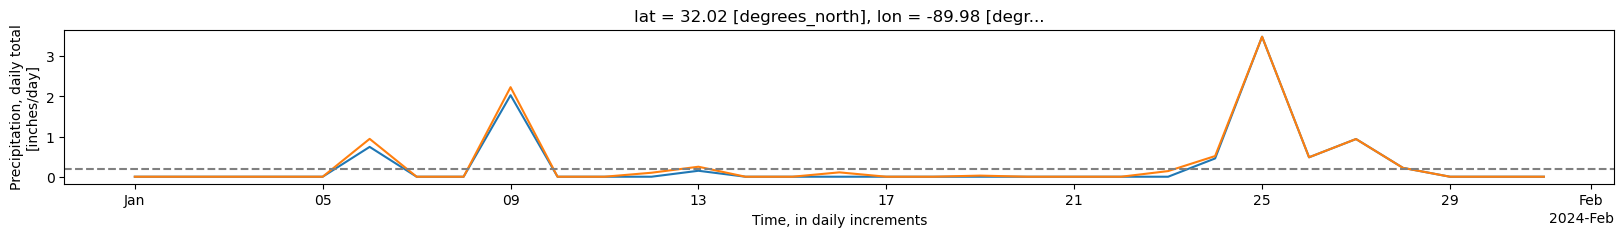

In [19]:
# compare pnet to pr to double check that everything worked correctly
time = '2024-01'
pnet.swap_dims({'time_index':'time'}).sel(time=time).plot(figsize=(20,2))
pr.sel(time=time).plot()
plt.axhline(acc_thresh,color='grey',ls='dashed')
plt.show()

#### Looks correct


# 4) load tmax data and calc mean annual precip

In [20]:
# load 5 years of data at a single grid, limit precision per metadata, and convert units

tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

tmax = (tmax *9/5) + 32
tmax_attrs = {'standard_name':'air_temperature','long_name':'Temperature, daily maximum','units':'F'}
tmax.attrs = tmax_attrs

tmax

<xarray.DataArray 'tmax' (time: 26907)> Size: 108kB
array([51.314, 65.57 , 65.642, ..., 97.088, 92.588, 89.204],
      shape=(26907,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature, daily maximum
    units:          F

In [21]:
# mean annual precip (inches)
mean_ann_pr = pr.groupby('time.year').sum(min_count=360).mean()
mean_ann_pr

<xarray.DataArray 'prcp' ()> Size: 8B
array(57.51311493)
Coordinates:
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0

# 5) Calculate KBDI 

## using inches and Fahrenheit

$$
KBDI_{t} = Q_{t} + \frac{(800 - Q_{t}) (0.968 e^{0.0486 T_{t}} - 8.30) Δt}{1 + 10.88 e^{-0.0441 P}} * 1^{-3}
$$

where: 

$Q_{t}$ = $max(0, KBDI_{t-1}$ − $Pnet_{t} * 100)$ is yesterday's KBDI adjusted by today's pnet

$Pnet_{t}$ is net precip (inches), real complicated see code above

$T_{t}$ is daily maximum temperature (F)

$Δt = 1$ (day)

$P$ is long term mean annual precip (inches)

and 

$KBDI_{t-1}$ is intialized to 0 at whatever time meets the wet condition criteria of 8 inches in a week, all times before that are nan


Just attempting to understand the numerator a bit better...

Text(0, 0.5, 'value of numerator exp term')

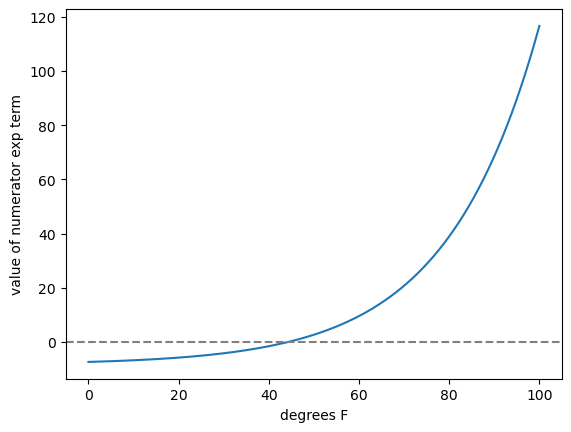

In [33]:
x = np.linspace(0,100,5000)
y = 0.968 * np.exp(0.0486*x) - 8.3

plt.plot(x,y)
plt.axhline(0,color='grey',ls='--')
plt.xlabel('degrees F')
plt.ylabel('value of numerator exp term')

This term  controls whether yesterday's value of KBDI is increased or decreased. The term will be negative when tmax <= 44.2F which will act to decrease the KBDI drought factor. When the term is greater than 44.2F it will be positive which acts to add to yesterday's KBDI value, increasing the drought factor.

There will be cases where this term will decrease the KBDI below zero, at which point the KBDI value will need to be corrected to zero. Otherwise, there will be negative KBDI values and those errors will propagate/accumulate throughout the timeseries.

In [54]:
# KBDI initialization, numpy arrays

KBDI = np.full(pr.shape,np.nan) # set all to nan
Q = KBDI.copy()
KBDI[day_int]=0   # set to 0 at saturation day

print(np.unique(KBDI))
KBDI.shape

[ 0. nan]


(26907,)

In [65]:
# convert all inputs to scalar or numpy for speed
pr_ann = mean_ann_pr.item()
pnet_np = pnet.data
tmax_np = tmax.data

array([51.314, 65.57 , 65.642, ..., 97.088, 92.588, 89.204],
      shape=(26907,), dtype=float32)

In [66]:
%%time
# KBDI calculation (inches, Fahrenheit)

# denom is time invariant, calculate outside of the time loop
denominator = 1 + 10.88 * np.exp(-0.0441*pr_ann)

# looping in time, starting on the day after KBDI is initialized to zero
for it in range(day_int+1,KBDI.shape[0]):
    # calc today's KBDI
    Q = max(0,KBDI[it-1] - pnet_np[it]*100) # today's Q = yesterday's KBDI adjusted by today's net precipitation
    numerator = (800 - Q) * (0.968 * np.exp(0.0486*tmax_np[it]) - 8.3)
    KBDI[it] = Q + (numerator/denominator)*1E-3  
    # adjust negative values to 0
    KBDI[it] =  min(max(KBDI[it], 0.0), 800.)
    del numerator,Q

CPU times: total: 46.9 ms
Wall time: 46.2 ms


In [52]:
# %%time
# # KBDI calculation (inches, Fahrenheit)

# # denominator is time invariant, calculate outside of the time loop
# denominator = (1 + 10.88 * np.exp(-0.0441*mean_ann_pr)).item()

# # # looping through time
# # for it in range(day_int+1,KBDI.shape[0]):
# #     Q[it] = max(0,KBDI[it-1] - pnet[it]*100)
# #     numerator = (800 - Q[it]) * (0.968 * np.exp(0.0486*tmax[it]) - 8.3)
# #     KBDI[it] = Q[it] + (numerator/denominator)*1E-3  
# #     del numerator

# # looping in time, save memory
# # starting on the day after KBDI is initialized to zero
# for it in range(day_int+1,KBDI.shape[0]):
#     Q = max(0,KBDI[it-1] - pnet[it]*100)
#     numerator = (800 - Q) * (0.968 * np.exp(0.0486*tmax[it]) - 8.3)
#     KBDI[it] = Q + (numerator/denominator)*1E-3  
#     KBDI[it] =  min(max(KBDI[it], 0.0), 800.)
#     # KBDI[it] =  max(KBDI[it], 0.0)

#     del numerator,Q

CPU times: total: 47 s
Wall time: 47.3 s


In [68]:
# convert to xarray object
KBDI = xr.DataArray(KBDI, coords = {'time':('time',pr.time.data)})
KBDI.coords['time_index'] = ('time',time_index)

# Q = xr.DataArray(Q, coords = {'time':('time',pr.time.data)})
# Q.coords['time_index'] = ('time',time_index)

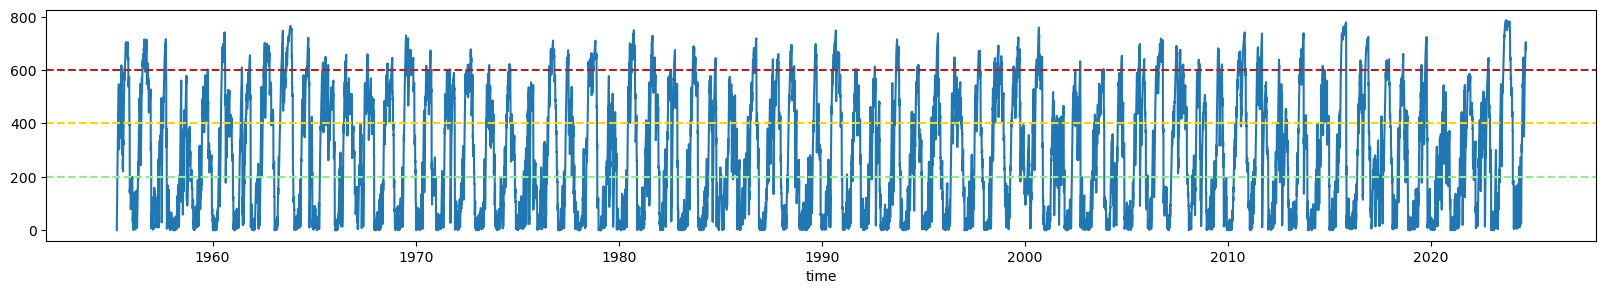

In [69]:
# plot KBDI

KBDI.plot(figsize=(20,3))
plt.axhline(200,color='lightgreen',ls='dashed')
plt.axhline(400,color='gold',ls='dashed')
plt.axhline(600,color='firebrick',ls='dashed')

In [70]:
# look at min/max
print(KBDI.min().item(), KBDI.max().item())

0.0 787.078302545507


Minimum should be zero. Check how many negatives are present

In [27]:
(KBDI<0).sum().item()

0

In [38]:
# neginds = []
# testvals=[]
# for it in range(day_int+1,KBDI.shape[0]):
#     test = (0.968 * np.exp(0.0486*tmax[it]) - 8.3)
#     if test<0:
#         neginds.append(it)
#         testvals.append(test.item())

In [39]:
# KBDI[neginds]

In [40]:
# min(testvals),max(testvals),np.mean(testvals)

In [101]:
# tmax[neginds]

In [102]:
# Q[neginds]


In [103]:
# Q.plot(figsize=(20,3))


In [104]:
# print(Q.min().item(),Q.max().item())

Look at the code from the xclim project

In [ ]:
def _keetch_byram_drought_index(p, t, pa, kbdi0, kbdi: float):  # pragma: no cover
    """
    Compute the Keetch-Byram drought (KBDI) index.

    Parameters
    ----------
    p : array_like
        Total rainfall over previous 24 hours [mm].
    t : array_like
        Maximum temperature near the surface over previous 24 hours [C].
    pa : float
        Mean annual accumulated rainfall.
    kbdi0 : float
        Previous value of the Keetch-Byram drought index used to initialise the KBDI calculation.

    Returns
    -------
    array_like
        Keetch-Byram drought index.
    """
    no_p = 0.0  # Where to define zero rainfall
    rr = 5.0  # Initialise remaining runoff

    for d in range(len(p)):  # pylint: disable=consider-using-enumerate
        # Calculate the runoff and remaining runoff for this timestep
        if p[d] <= no_p:
            r = p[d]
            rr = 5.0
        else:
            r = min(p[d], rr)
            rr -= r

        Peff = p[d] - r
        ET = (
            1e-3
            * (203.2 - kbdi0)
            * (0.968 * np.exp(0.0875 * t[d] + 1.5552) - 8.3)
            / (1 + 10.88 * np.exp(-0.00173 * pa))
        )

        kbdi0 += ET - Peff

        # Limit kbdi to between 0 and 200 mm
        kbdi0 = min(max(kbdi0, 0.0), 203.2)

        kbdi[d] = kbdi0  # type: ignore

In [41]:
p = pr.data * 25.4 # mm/day

# init kbdi
kbdi0=0.
kbdi=KBDI.copy(deep=True).data
kbdi[:]=np.nan
kbdi[day_int]=0

t = (tmax.copy(deep=True).data -32) *5/9 # F to C
pa= mean_ann_pr.data*25.4 # mm/day

kbdi

array([nan, nan, nan, ..., nan, nan, nan], shape=(26907,))

In [45]:
no_p = 0.0  # Where to define zero rainfall
rr = 5.0  # Initialise remaining runoff

# for d in range(len(p)):  
for d in range(day_int+1,len(p)):
    # Calculate the runoff and remaining runoff for this timestep
    if p[d] <= no_p:
        r = p[d]
        rr = 5.0
    else:
        r = min(p[d], rr)
        rr -= r

    Peff = p[d] - r
    ET = (
        1e-3
        * (203.2 - kbdi0)
        * (0.968 * np.exp(0.0875 * t[d] + 1.5552) - 8.3)
        / (1 + 10.88 * np.exp(-0.00173 * pa))
    )

    kbdi0 += ET - Peff

    # Limit kbdi to between 0 and 200 mm
    kbdi0 = min(max(kbdi0, 0.0), 203.2)

    kbdi[d] = kbdi0  # type: ignore

Why is this code so much faster than the KBDI calc I wrote earlier??? Is it really numpy vs xarray

Wow, the answer is yes. Converting all data to numpy arrays before the time loop makes a 47s xarray calc take less than 1s with numpy only. What the heck is that all about. Note to self, looping on xarray data structures is ridiculously slow compared to numpy.

In [46]:
kbdi= xr.DataArray(kbdi, coords = {'time':('time',pr.time.data)})
kbdi.coords['time_index'] = ('time',time_index)


In [47]:
test = (kbdi/203.2)*800
print(test.min().item(),test.max().item())
print(KBDI.min().item(),KBDI.max().item())

0.0 786.2948048861341
0.0 787.0783025447851


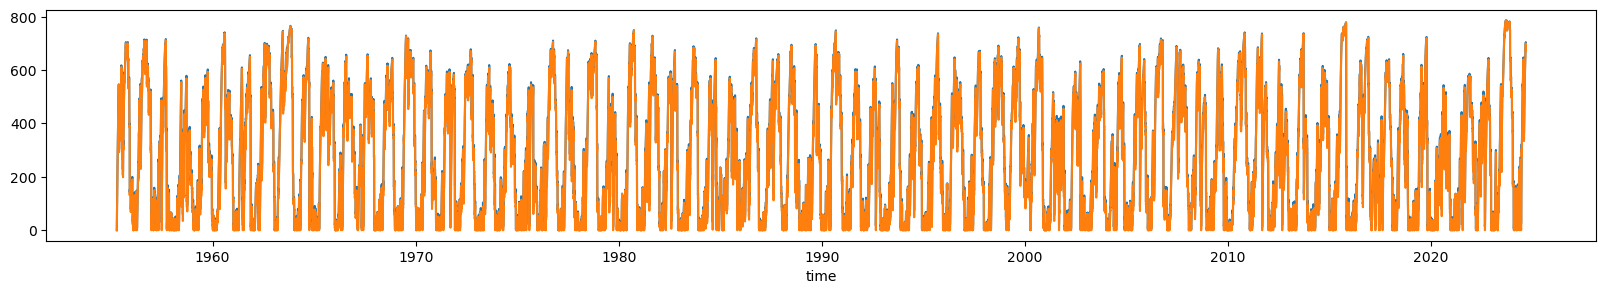

In [110]:
fig = plt.figure(figsize=(20,3))
KBDI.plot()
test.plot()
plt.show()


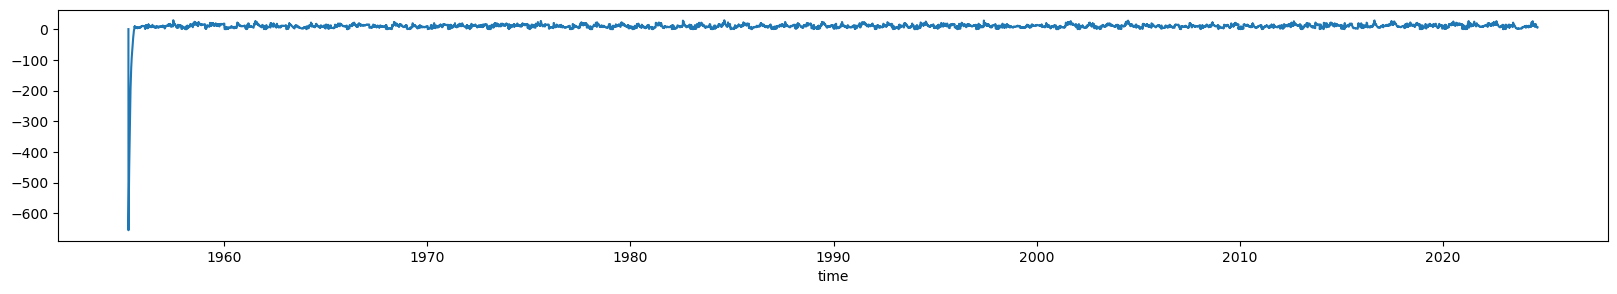

In [48]:
(KBDI-test).plot(figsize=(20,3))

AttributeError: 'numpy.ndarray' object has no attribute 'isel'

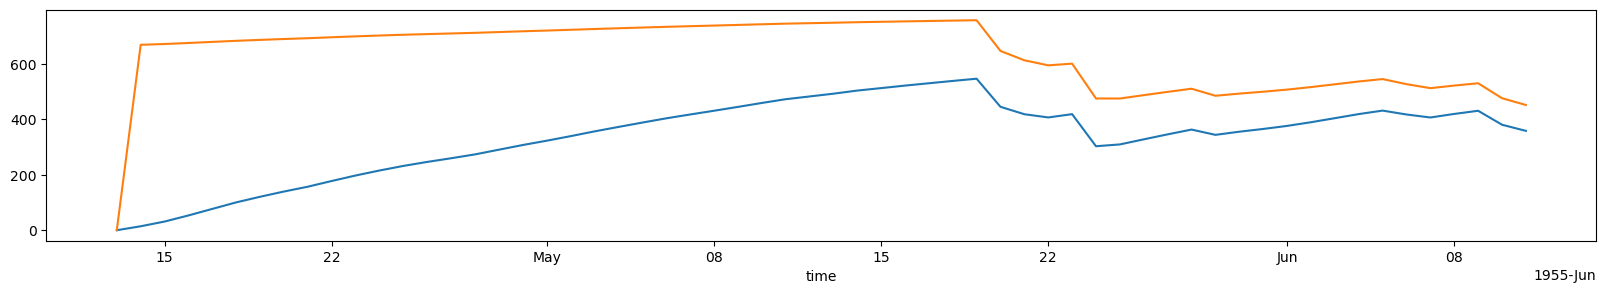

In [51]:
fig = plt.figure(figsize=(20,3))
KBDI.isel(time=slice(day_int,day_int+60)).plot()
test.isel(time=slice(day_int,day_int+60)).plot()
plt.bar(p.isel(time=slice(day_int,day_int+60))*100)
plt.show()

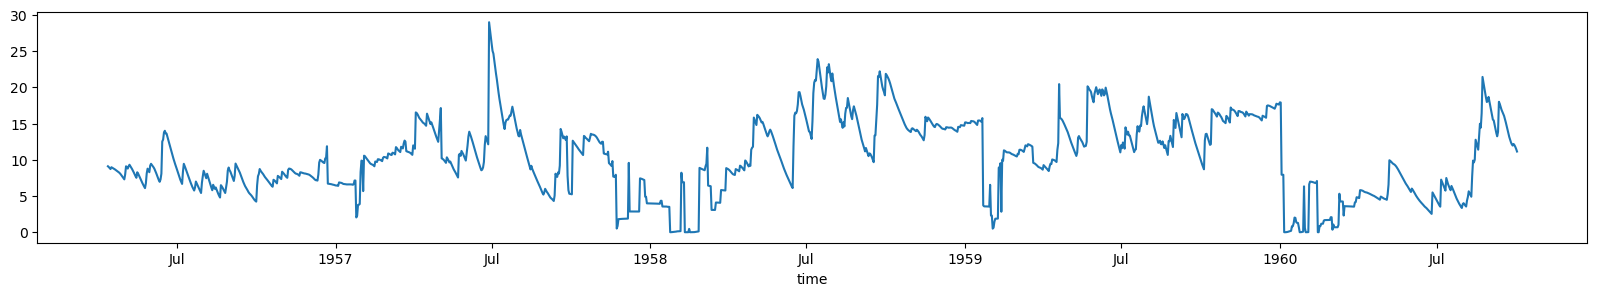

In [75]:
(KBDI.isel(time=slice(day_int+365,day_int+2000))-test.isel(time=slice(day_int+365,day_int+2000))).plot(figsize=(20,3))

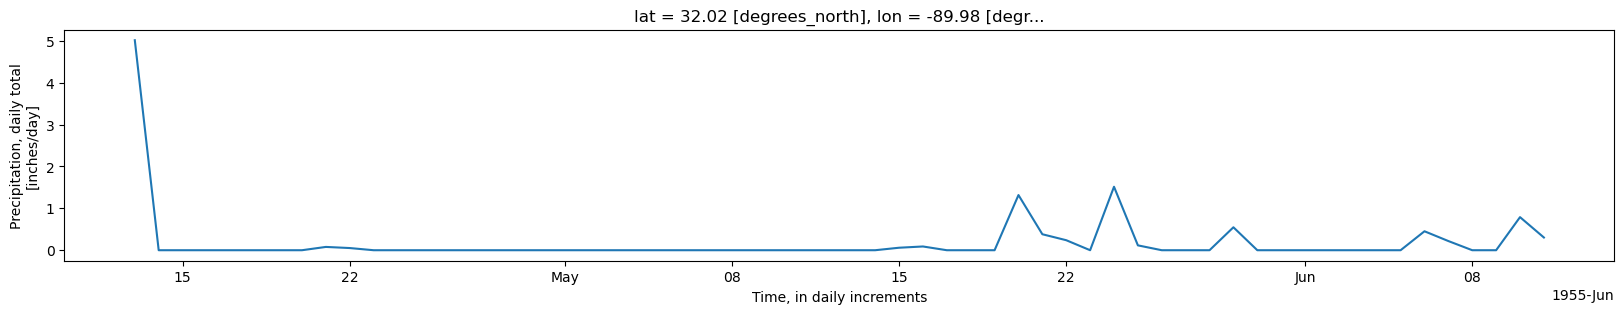

In [117]:
pr.isel(time=slice(day_int,day_int+60)).plot(figsize=(20,3))


The difference between my calc and clim is present even when there is no rain, but is most visible when there is rain. Try to track down this difference. When you remove the forced bounds 0-203.2 in the xclim version, the kbdi values go very negative so that's real suspicious.

In [ ]:
# compare with parallel claude algorithm
kbdi_file = r'D://data/NERRfire_analysis_outputs/KBDI/kbdi_nclimgrid_1951_2024.nc'#' #D:\data\NERRfire_analysis_outputs\KBDI
test = xr.open_dataset(kbdi_file).kbdi.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest')
test


In [ ]:
(KBDI-test).plot(figsize=(20,3))

In [ ]:
# # for debugging if needed
# pnet = pnet.swap_dims({'time_index':'time'})
# Q = xr.DataArray(Q, coords = {'time':('time',pr.time.data)})
# Q.coords['time_index'] =('time',time_index)

In [ ]:
# # for debugging if needed
# time1='2024-01-20'
# time2='2024-02-16'
# ndays = pnet.sel(time=slice(time1,time2)).shape[0]

# fig = plt.figure(figsize=(20,2))
# plt.plot(Q.sel(time=slice(time1,time2)))               # orange
# plt.plot(KBDI.sel(time=slice(time1,time2)))            # green
# plt.title("KBDI = orange, Q = blue")
# plt.xlim(0,ndays)
# plt.show()

# fig = plt.figure(figsize=(20,2))
# plt.bar(range(ndays),(pnet*100).sel(time=slice(time1,time2))) # blue
# plt.plot(range(ndays),(pr*100).sel(time=slice(time1,time2)),color='orange',marker='o',lw=0) # blue
# # plt.plot(tmax.sel(time=slice(time1,time2)))            # green
# plt.title("bars = pnet, dots = pr")
# plt.xlim(0,ndays)
# plt.show()

# fig = plt.figure(figsize=(20,2))
# plt.plot(tmax.sel(time=slice(time1,time2)))            # green
# plt.title("tmax")
# plt.xlim(0,ndays)
# plt.show()

# print(pr.sel(time=slice(time1,time2)).data) # inches
# print(pnet.sel(time=slice(time1,time2)).data) # inches
# print(tmax.sel(time=slice(time1,time2)).data) # F
# print(mean_ann_pr.item()) #inches

# 6) Compare against online info


Using the current KBDI map from [Wildland Fire Assessment System](https://www.wfas.net/index.php?option=com_content&view=article&id=86&Itemid=487#:~:text=Keetch%20and%20Byram%20(1968)%20designed,duff%20and%20upper%20soil%20layers.) for today May 22, 2025, the KBDI is in the 201-300 range for this point. 

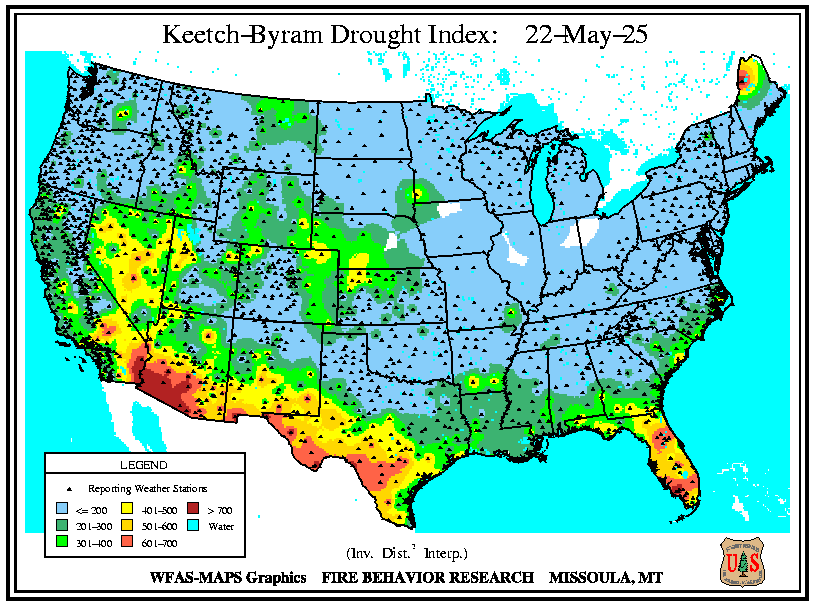

In [ ]:
KBDI.sel(time=(KBDI.time.dt.month==5)&(KBDI.time.dt.day==22))

values look reasonable

## A little more quantification

What percent of the days fall into each category of KBDI?

- KBDI = 0 - 200: Soil moisture and large class fuel moistures are high and do not contribute much to fire intensity. Typical of spring dormant season following winter precipitation.
- KBDI = 200 - 400: Typical of late spring, early growing season. Lower litter and duff layers are drying and beginning to contribute to fire intensity.
- KBDI = 400 - 600: Typical of late summer, early fall. Lower litter and duff layers actively contribute to fire intensity and will burn actively.
- KBDI = 600 - 800: Often associated with more severe drought with increased wildfire occurrence. Intense, deep burning fires with significant downwind spotting can be expected. Live fuels can also be expected to burn actively at these levels.

In [ ]:
# initialize
KBDIcat = KBDI.copy()
KBDIcat[:]=np.nan

KBDIcat = xr.where(KBDI>=200,1,KBDIcat)
KBDIcat = xr.where((201<=KBDI)&(KBDI<=400),2,KBDIcat)
KBDIcat = xr.where((401<=KBDI)&(KBDI<=600),3,KBDIcat)
KBDIcat = xr.where((601<=KBDI)&(KBDI<=800),4,KBDIcat)

ndays = np.isfinite(KBDIcat).sum().item()

for c in [1,2,3,4]:
    percent_cat = round((KBDIcat==c).sum().item()/ndays*100,2)
    print(f'{percent_cat}% of days in the timeseries are KBDI category {c}')

values look reasonable

# 7) Create Functions

### try one big func first, calculation at single grid

In [122]:
def calc_kbdi(T,PR):
    # determine if the grid is land or water
    landmask=1 if np.isfinite(PR.mean('time')) else 0
    
    # create an integer time index coordinate since datetimes will give us some trouble
    # time_index=np.arange(0,len(PR.time)).astype('int')
    # PR.coords['time_index']=('time',time_index)
    
    
    # sum precip in 7 day rolling windows
    ndays=7
    pr_thresh=8 # inches
    pr_weeksum=PR.rolling(time=ndays,min_periods=ndays,center=False).sum()
    
    
    # get the first index time where the weekly sum meets the threshold
    # this is index t-1 for the KBDI calc where we'll set it to 0
    # day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
    day_int = np.argwhere(pr_weeksum.data>pr_thresh).flatten()[0] 
    
    
    # calculate number of consecutive rain days at each time step
    # I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
    rainmask=xr.where(PR>0,1,0) # 1/0 rain/no rain mask
    # rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
    rr = (rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)).data

    
    # categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)
    # first swap out the time coordinate for the time_index
    # rr_swap = rr.swap_dims({'time':'time_index'})
    # label all days that are at least the 3rd consecutive rainfall day with a 5
    # cat=xr.where(rr_swap>=3,5,rr_swap)
    cat=np.where(rr>=3,5,rr)
    # find the indexes of all second consecutive rainfall days
    # consec_day2 = np.argwhere(rr_swap.data==2).flatten()
    consec_day2 = np.argwhere(rr==2).flatten()
    # find the indexes of all the first consecutive rainfall days
    consec_day1 = consec_day2-1
    # label all consecutive rainfall days with a 2 
    cat[consec_day2]=5 # first put a 5
    cat[consec_day1]=5 # first put a 5
    # cat = xr.where(cat==5,2,cat) # convert to 2's
    cat = np.where(cat==5,2,cat) # convert to 2's
    # should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
    # np.unique(cat) # change to assert
    
    
    # Calc Pnet 
    acc_thresh = 0.2 # inches
    # Category 0 (no rain days)
    # pnet will be zero where pr is zero
    # pnet = PR.swap_dims({'time':'time_index'})
    pr_np = PR.copy().data
    pnet = pr_np.copy()
    # Category 1 (single rain days)
    # pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
    # pnet = xr.where(pnet<0,0,pnet)
    pnet = np.where(cat==1,pnet-acc_thresh,pnet)
    pnet = np.where(pnet<0,0,pnet)
    # Category 2 (consecutive rain days) 
    # consec_inds = cat[cat==2].time_index
    consec_inds = np.argwhere(cat==2).flatten()
    # initializations
    thresh_flag=False
    end_event=False
    accpr=0. 
    # loop through days in each multi-day rain event
    for i,ind in enumerate(consec_inds): 
        # accumulated precip per rain event
        # accpr=accpr+PR[ind].item() 
        accpr=accpr+pr_np[ind].item() 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet[ind]=0        
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet[ind]=accpr
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            # pnet[ind]=PR[ind].item()     
            pnet[ind]=pr_np[ind]     
        # reset accumulation and flag for the next consecutive rain event
        if i != len(consec_inds)-1:
            if (consec_inds[i+1] != consec_inds[i]+1): 
                accpr=0.
                thresh_flag=False
    
    
    # mean annual precip (inches)
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean().item()
    
    # KBDI initialization
    KBDI = np.full(PR.shape,np.nan) # set all to nan
    Q = KBDI.copy()
    KBDI[day_int]=0   # set to 0 at saturation day t-1
    # print(np.unique(KBDI)) # change to assert

    # convert all inputs to scalar or numpy for speed
    # pr_ann = mean_ann_pr.item()
    pnet_np = pnet.copy()#.data
    T_np = T.data
    
    
    # KBDI calculation (inches, Fahrenheit)
    denominator = 1 + 10.88 * np.exp(-0.0441*mean_ann_pr)
    # looping in time, save memory
    for it in range(day_int+1,KBDI.shape[0]):
        Q = max(0,KBDI[it-1] - pnet_np[it]*100)
        numerator = (800 - Q) * (0.968 * np.exp(0.0486*T_np[it]) - 8.3)
        KBDI[it] = Q + (numerator/denominator)*1E-3  
        KBDI[it] =  min(max(KBDI[it], 0.0), 800.)
        del numerator,Q
    # convert to xarray
    KBDI = xr.DataArray(KBDI, coords = {'time':('time',PR.time.data)})
    KBDI.coords['time_index'] = ('time',time_index)
    return KBDI

In [123]:
%%time

year_start='1951'
year_end='2024'
lat = 32
lon = -90

pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

pr = pr / 25.4
pr_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
pr.attrs = pr_attrs

tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

tmax = (tmax *9/5) + 32
tmax_attrs = {'standard_name':'air_temperature','long_name':'Temperature, daily maximum','units':'F'}
tmax.attrs = tmax_attrs

In [124]:
%%time
test = calc_kbdi(tmax,pr)
test

CPU times: total: 78.1 ms
Wall time: 87.4 ms


<xarray.DataArray (time: 26907)> Size: 215kB
array([         nan,          nan,          nan, ..., 704.69337516,
       697.38075665, 677.29698186], shape=(26907,))
Coordinates:
  * time        (time) datetime64[ns] 215kB 1951-01-01 1951-01-02 ... 2024-08-31
    time_index  (time) int32 108kB 0 1 2 3 4 5 ... 26902 26903 26904 26905 26906

# How long does each part of the function take?

In [81]:
%%html
<style>
  table {
    float: left;
  }
</style>

#### first order calcs
input | |output
---|---|---
pr |-->| mean_ann_pr
pr |-->| time_index
pr |-->| init date
pr |-->| rr
<br>



#### second order calcs
input | |output
---|---|---
mean_ann_pr |-->| landmask
rr |-->| cat



#### third order calcs (loops thru indexes)
input | |output
---|---|---
pr,cat |-->| pnet



#### fourth order calcs (loops thru time)
input | |output
---|---|---
pnet,T,init date,mean_ann_pr |-->| kbdi

In [86]:
%%time

def func1(PR):
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean('year').item()
    
    # determine if the grid is land or water
    landmask=1 if np.isfinite(mean_ann_pr) else 0
    
    # create an integer time index coordinate since datetimes will give us some trouble
    time_index=np.arange(len(PR.time),dtype='int32')
    PR.coords['time_index']=('time',time_index)

    return mean_ann_pr,landmask,time_index,PR

mean_ann_pr,landmask,time_index,PR = func1(pr)

CPU times: total: 31.2 ms
Wall time: 24.7 ms


In [82]:
%%time
def func2(PR):
    # sum precip in 7 day rolling windows
    ndays=7
    pr_thresh=8 # inches
    pr_weeksum=PR.rolling(time=ndays,min_periods=ndays,center=False).sum()
    
    
    # get the first index time where the weekly sum meets the threshold
    # this is index t-1 for the KBDI calc where we'll set it to 0
    day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
    return day_int

day_int = func2(pr)

CPU times: total: 0 ns
Wall time: 2.1 ms


In [ ]:
# day_int.dtype

In [83]:
%%time
def func3(PR):
    # calculate number of consecutive rain days at each time step
    # I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
    rainmask=xr.where(PR>0,1,0) # 1/0 rain/no rain mask
    rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
    return rr

rr = func3(pr)

CPU times: total: 0 ns
Wall time: 3.77 ms


In [ ]:
rr.dtype

In [84]:
%%time
def func4(RR):
    # categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)
    # first swap out the time coordinate for the time_index
    rr_swap = RR.swap_dims({'time':'time_index'})
    # label all days that are at least the 3rd consecutive rainfall day with a 5
    cat=xr.where(rr_swap>=3,5,rr_swap)
    # find the indexes of all second consecutive rainfall days
    consec_day2 = np.argwhere(rr_swap.data==2).flatten()
    # find the indexes of all the first consecutive rainfall days
    consec_day1 = consec_day2-1
    # label all consecutive rainfall days with a 2 
    cat[consec_day2]=5 # first put a 5
    cat[consec_day1]=5 # first put a 5
    cat = xr.where(cat==5,2,cat) # convert to 2's
    # should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
    # np.unique(cat) # change to assert
    return cat

cat = func4(rr)

CPU times: total: 0 ns
Wall time: 3.1 ms


In [89]:
cat.dtype

dtype('float64')

In [91]:
cat

<xarray.DataArray 'prcp' (time_index: 26907)> Size: 215kB
array([0., 2., 2., ..., 2., 2., 2.], shape=(26907,))
Coordinates:
    time         (time_index) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
  * time_index   (time_index) int32 108kB 0 1 2 3 4 ... 26903 26904 26905 26906

In [ ]:
cat.sel(time_index=slice(0,30)).plot()


In [88]:
%%time
def func5(PR,CAT):
    # Calc Pnet 
    acc_thresh = 0.2 # inches
    # Category 0 (no rain days) pnet will be zero where pr is zero
    pnet = PR.swap_dims({'time':'time_index'})
    # Category 1 (single rain days)
    pnet = xr.where(CAT==1,pnet-acc_thresh,pnet)
    pnet = xr.where(pnet<0,0,pnet)
    # Category 2 (consecutive rain days) 
    consec_inds = CAT[CAT==2].time_index
    # initializations
    thresh_flag=False
    end_event=False
    accpr=0. 
    # numpy conversion for speed
    PR_np = PR.data
    pnet_np = pnet.data
    # loop through days in each multi-day rain event
    for i,ind in enumerate(consec_inds): 
        # accumulated precip per rain event
        # accpr=accpr+PR[ind].item() 
        accpr=accpr+PR_np[ind] 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet_np[ind]=0        
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet_np[ind]=accpr
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            # pnet[ind]=PR[ind].item()     
            pnet_np[ind]=PR_np[ind]     
        # reset accumulation and flag for the next consecutive rain event
        if i != len(consec_inds)-1:
            if (consec_inds[i+1] != consec_inds[i]+1): 
                accpr=0.
                thresh_flag=False
    return pnet_np

pnet = func5(pr,cat)

CPU times: total: 3.08 s
Wall time: 3.12 s


In [114]:
%%time
def func5(PR,CAT):
    # Calc Pnet 
    acc_thresh = 0.2 # inches
    # numpy conversion for speed
    PR_np = PR.data
    cat_np = CAT.data
    pnet_np = PR_np.copy()
    # Category 0 (no rain days) pnet will be zero where pr is zero
    # pnet = PR.swap_dims({'time':'time_index'})
    # Category 1 (single rain days)
    pnet_np = np.where(cat_np==1,pnet_np-acc_thresh,pnet_np)
    pnet_np = xr.where(pnet_np<0,0,pnet_np)
    # Category 2 (consecutive rain days) 
    # consec_inds = CAT[CAT==2].time_index
    consec_inds = np.argwhere(cat_np==2).flatten()
    # initializations
    thresh_flag=False
    end_event=False
    accpr=0. 
    # # # numpy conversion for speed
    # # PR_np = PR.data
    # # pnet_np = pnet.data
    # loop through days in each multi-day rain event
    for i,ind in enumerate(consec_inds): 
        # accumulated precip per rain event
        # accpr=accpr+PR[ind].item() 
        accpr=accpr+PR_np[ind] 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet_np[ind]=0        
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet_np[ind]=accpr
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            # pnet[ind]=PR[ind].item()     
            pnet_np[ind]=PR_np[ind]     
        # reset accumulation and flag for the next consecutive rain event
        if i != len(consec_inds)-1:
            if (consec_inds[i+1] != consec_inds[i]+1): 
                accpr=0.
                thresh_flag=False
    return pnet_np

pnet = func5(pr,cat)

CPU times: total: 15.6 ms
Wall time: 5.93 ms


In [104]:
pnet

array([0.        , 0.1043307 , 0.9775591 , ..., 0.        , 0.11850391,
       0.24566929], shape=(26907,), dtype=float32)

In [102]:
pnet_np = pr.copy().data
pnet_np = np.where(cat.data==1,pnet_np-acc_thresh,pnet_np)
pnet_np = xr.where(pnet_np<0,0,pnet_np)
consec_inds = np.argwhere(cat.data==2)
consec_inds

array([[    1],
       [    2],
       [    3],
       ...,
       [26904],
       [26905],
       [26906]], shape=(6126, 1))

In [85]:
%%time

# using more_itertools and dask delayed to parallelize pnet calc

# consec_inds = cat[cat==2].time_index
# events=[]
# for group in consecutive_groups(consec_inds.data):
#     events.append(np.array(list(group)))

def pnet_per_event(event_pr,acc_thresh):
    # pnet = []
    pnet =np.full_like(event_pr,np.nan,dtype='float32')    
    thresh_flag=False
    end_event=False
    accpr=0. 
    # loop through days in each multi-day rain event
    for i,PR in enumerate(event_pr): 
        # accumulated precip per rain event
        accpr=accpr+PR.item() 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet[i]=0        
            # pnet.append(0)
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet[i]=accpr
            # pnet.append(accpr)
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            pnet[i]=PR.item() 
            # pnet.append(PR.item())
    return pnet

# acc_thresh = 0.2 # inches
# task_list = [dask.delayed(pnet_per_event)(pr[event_inds],acc_thresh) for event_inds in events]
# result = dask.compute(*task_list)

# # Category 0 (no rain days) pnet will be zero where pr is zero
# PNET = PR.swap_dims({'time':'time_index'})
# # Category 1 (single rain days)
# PNET = xr.where(cat==1,PNET-acc_thresh,PNET)
# PNET = xr.where(PNET<0,0,PNET)
# # Category 2 (consecutive rain days)
# PNET[consec_inds]=np.concatenate(result)

CPU times: total: 0 ns
Wall time: 4.53 μs


In [110]:
%%time
def func7(pnet,day_int,mean_ann_pr,T):
    # KBDI initialization
    KBDI = np.full(pnet.shape,np.nan,dtype='float16') # set all to nan
    KBDI[day_int]=0   # set to 0 at saturation day t-1    

    # convert all inputs to scalar or numpy for speed
    pnet_np = pnet#.data
    T_np = T.data
    
    # KBDI calculation (inches, Fahrenheit)
    denominator = 1 + 10.88 * np.exp(-0.0441*mean_ann_pr)
    
    # looping in time starting at init day
    for it in range(day_int+1,KBDI.shape[0]):
        Q = max(0,KBDI[it-1] - pnet_np[it]*100)
        numerator = (800 - Q) * (0.968 * np.exp(0.0486*T_np[it]) - 8.3)
        KBDI[it] = Q + (numerator/denominator)*1E-3  
        KBDI[it] =  min(max(KBDI[it], 0.0), 800.)
        del numerator,Q
        
    # convert to xarray
    KBDI = xr.DataArray(KBDI, coords = {'time':('time',T.time.data)})
    # KBDI.coords['time_index'] = ('time',T.time_index.data)
    return KBDI    
    
# kbdi = func7(PNET,day_int,mean_ann_pr,tmax)
kbdi = func7(pnet,day_int,mean_ann_pr,tmax)
kbdi

CPU times: total: 93.8 ms
Wall time: 73 ms


<xarray.DataArray (time: 26907)> Size: 54kB
array([  nan,   nan,   nan, ..., 704. , 696.5, 676.5],
      shape=(26907,), dtype=float16)
Coordinates:
  * time     (time) datetime64[ns] 215kB 1951-01-01 1951-01-02 ... 2024-08-31

In [107]:
pnet

array([0.        , 0.1043307 , 0.9775591 , ..., 0.        , 0.11850391,
       0.24566929], shape=(26907,), dtype=float32)

In [ ]:
def new_func(PR,T):
    mean_ann_pr,landmask,time_index,pr = func1(PR)  
    day_int = func2(pr)
    rr = func3(pr)
    cat = func4(rr)    
    
    # using more_itertools and dask delayed to parallelize pnet calc
    consec_inds = cat[cat==2].time_index
    events=[]
    for group in consecutive_groups(consec_inds.data):
        events.append(np.array(list(group)))
    
    acc_thresh = 0.2 # inches    
    task_list = [dask.delayed(pnet_per_event)(pr[event_inds],acc_thresh) for event_inds in events]
    result = dask.compute(*task_list)
    
    # Category 0 (no rain days) pnet will be zero where pr is zero
    pnet = pr.swap_dims({'time':'time_index'})
    # Category 1 (single rain days)
    pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
    pnet = xr.where(pnet<0,0,pnet)
    # Category 2 (consecutive rain days)
    pnet[consec_inds]=np.concatenate(result)
    
    kbdi = func7(pnet,day_int,mean_ann_pr,T)
    return kbdi
    # return pnet

In [ ]:
%%time
# test faster func
kbdi = new_func(pr,tmax)
kbdi
# PNET = new_func(pr,tmax)

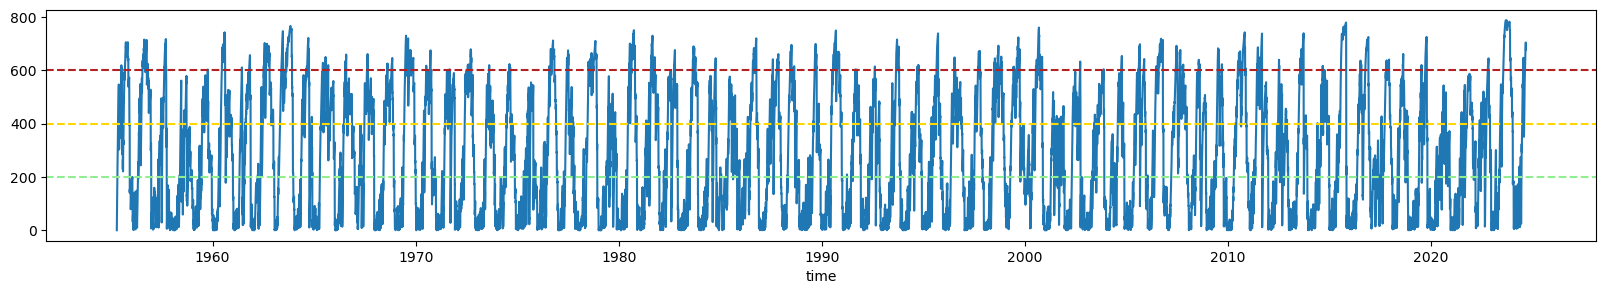

In [115]:
kbdi.plot(figsize=(20,3))
plt.axhline(200,color='lightgreen',ls='dashed')
plt.axhline(400,color='gold',ls='dashed')
plt.axhline(600,color='firebrick',ls='dashed')

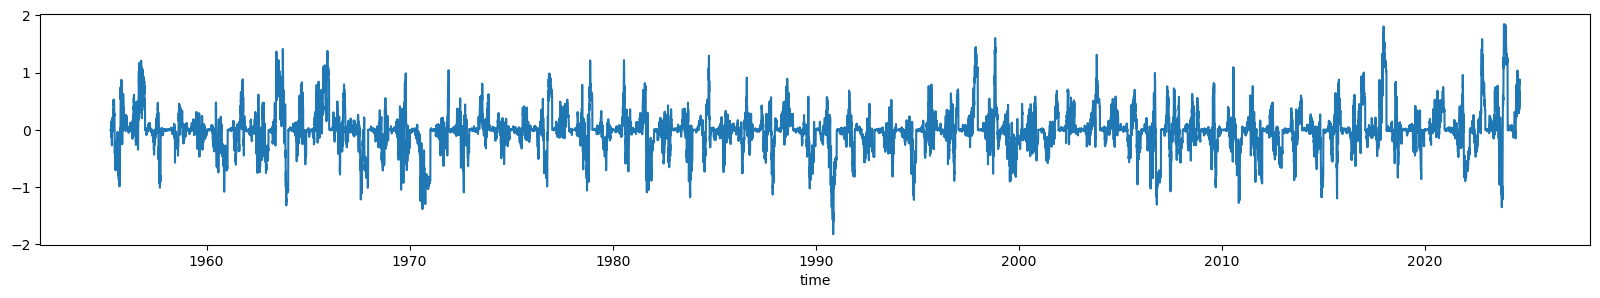

In [116]:
(KBDI-kbdi).plot(figsize=(20,3))

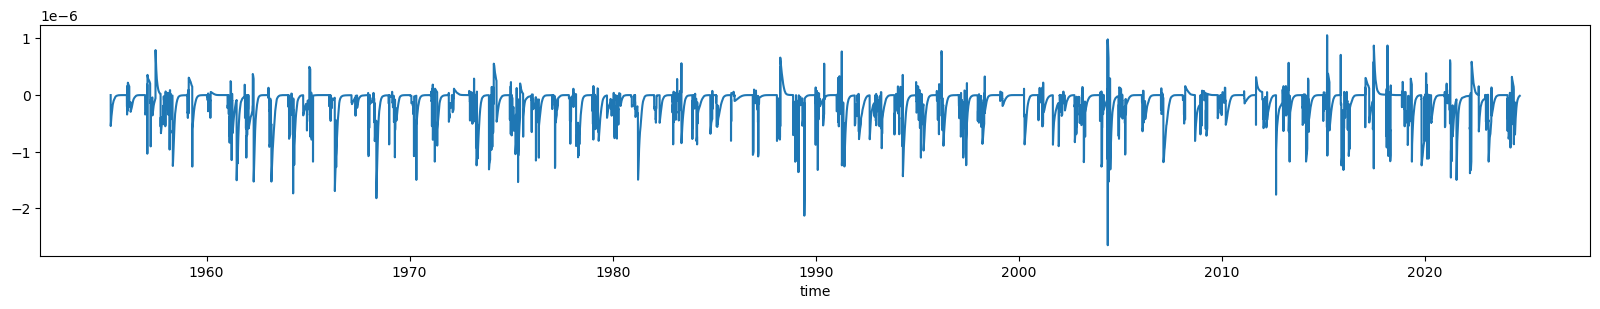

In [125]:
(test-KBDI).plot(figsize=(20,3))

I think this kbdi error is from precision differences. But I should check the individual components before finalizing or running this on the HPC


Vectorize the fast comps for the whole grid and write to disk. Most of those vectorized funcs are already written in test_parallel

Then set up a parallelized pnet calc for the whole grid. May have to eliminate the interior parallelization of the pr events in favor of parallelization of grids. Write to file. Est 1hr calc time at 400 cores.

Then set up a parallelized kbdi calc for the whole grid. Est 5.3hr calc time at 400 cores.

In [ ]:
KBDI.to_netcdf('KBDI.nc')

In [ ]:
KBDI.dtype, kbdi.dtype

In [ ]:
kbdi.astype('float32').to_netcdf('kbdi.nc')

In [ ]:
pnet

In [ ]:
print(pnet.dtype,pnet.min().item(),pnet.max().item())
print(PNET.dtype,PNET.min().item(),PNET.max().item())

In [ ]:
def calc_kbdi(T,PR):
    # mean annual precip (inches)
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean('year')
    
    # determine if the grid is land or water
    landmask=1 if np.isfinite(mean_ann_pr) else 0
    
    # create an integer time index coordinate since datetimes will give us some trouble
    time_index=np.arange(len(PR.time),dtype='int32')
    PR.coords['time_index']=('time',time_index)
    
    
    # sum precip in 7 day rolling windows
    ndays=7
    pr_thresh=8 # inches
    pr_weeksum=PR.rolling(time=ndays,min_periods=ndays,center=False).sum()
    
    
    # get the first index time where the weekly sum meets the threshold
    # this is index t-1 for the KBDI calc where we'll set it to 0
    day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
    
    
    # calculate number of consecutive rain days at each time step
    # I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
    rainmask=xr.where(PR>0,1,0) # 1/0 rain/no rain mask
    rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
    
    
    # categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)
    # first swap out the time coordinate for the time_index
    rr_swap = rr.swap_dims({'time':'time_index'})
    # label all days that are at least the 3rd consecutive rainfall day with a 5
    cat=xr.where(rr_swap>=3,5,rr_swap)
    # find the indexes of all second consecutive rainfall days
    consec_day2 = np.argwhere(rr_swap.data==2).flatten()
    # find the indexes of all the first consecutive rainfall days
    consec_day1 = consec_day2-1
    # label all consecutive rainfall days with a 2 
    cat[consec_day2]=5 # first put a 5
    cat[consec_day1]=5 # first put a 5
    cat = xr.where(cat==5,2,cat) # convert to 2's
    # should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
    # np.unique(cat) # change to assert
    
    
    # Calc Pnet 
    acc_thresh = 0.2 # inches
    # Category 0 (no rain days)
    # pnet will be zero where pr is zero
    pnet = PR.swap_dims({'time':'time_index'})
    # Category 1 (single rain days)
    pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
    pnet = xr.where(pnet<0,0,pnet)
    # Category 2 (consecutive rain days) 
    consec_inds = cat[cat==2].time_index
    # initializations
    thresh_flag=False
    end_event=False
    accpr=0. 
    # loop through days in each multi-day rain event
    for i,ind in enumerate(consec_inds): 
        # accumulated precip per rain event
        accpr=accpr+PR[ind].item() 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet[ind]=0        
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet[ind]=accpr
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            pnet[ind]=PR[ind].item()     
        # reset accumulation and flag for the next consecutive rain event
        if i != len(consec_inds)-1:
            if (consec_inds[i+1] != consec_inds[i]+1): 
                accpr=0.
                thresh_flag=False
    
    
    # mean annual precip (inches)
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean()
    
    # KBDI initialization
    KBDI = np.full(PR.shape,np.nan) # set all to nan
    Q = KBDI.copy()
    KBDI[day_int]=0   # set to 0 at saturation day t-1
    # print(np.unique(KBDI)) # change to assert
    
    
    # KBDI calculation (inches, Fahrenheit)
    denominator = 1 + 10.88 * np.exp(-0.0441*mean_ann_pr)
    # looping in time, save memory
    for it in range(day_int+1,KBDI.shape[0]):
        Q = max(0,KBDI[it-1] - pnet[it]*100)
        numerator = (800 - Q) * (0.968 * np.exp(0.0486*T[it]) - 8.3)
        KBDI[it] = Q + (numerator/denominator)*1E-3  
        del numerator,Q
    # convert to xarray
    KBDI = xr.DataArray(KBDI, coords = {'time':('time',PR.time.data)})
    KBDI.coords['time_index'] = ('time',time_index)
    return KBDI

# for claude

In [ ]:
def calc_kbdi(T,PR):
    # determine if the grid is land or water
    landmask=1 if np.isfinite(PR.mean('time')) else 0
    
    # create an integer time index coordinate since datetimes will give us some trouble
    time_index=np.arange(0,len(PR.time)).astype('int')
    PR.coords['time_index']=('time',time_index)
    
    
    # sum precip in 7 day rolling windows
    ndays=7
    pr_thresh=8 # inches
    pr_weeksum=PR.rolling(time=ndays,min_periods=ndays,center=False).sum()
    
    
    # get the first index time where the weekly sum meets the threshold
    # this is index t-1 for the KBDI calc where we'll set it to 0
    day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
    
    
    # calculate number of consecutive rain days at each time step
    # I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
    rainmask=xr.where(PR>0,1,0) # 1/0 rain/no rain mask
    rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
    
    
    # categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)
    # first swap out the time coordinate for the time_index
    rr_swap = rr.swap_dims({'time':'time_index'})
    # label all days that are at least the 3rd consecutive rainfall day with a 5
    cat=xr.where(rr_swap>=3,5,rr_swap)
    # find the indexes of all second consecutive rainfall days
    consec_day2 = np.argwhere(rr_swap.data==2).flatten()
    # find the indexes of all the first consecutive rainfall days
    consec_day1 = consec_day2-1
    # label all consecutive rainfall days with a 2 
    cat[consec_day2]=5 # first put a 5
    cat[consec_day1]=5 # first put a 5
    cat = xr.where(cat==5,2,cat) # convert to 2's
    # should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
    # np.unique(cat) # change to assert
    
    
    # Calc Pnet 
    acc_thresh = 0.2 # inches
    # Category 0 (no rain days)
    # pnet will be zero where pr is zero
    pnet = PR.swap_dims({'time':'time_index'})
    # Category 1 (single rain days)
    pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
    pnet = xr.where(pnet<0,0,pnet)
    # Category 2 (consecutive rain days) 
    consec_inds = cat[cat==2].time_index
    # initializations
    thresh_flag=False
    end_event=False
    accpr=0. 
    # loop through days in each multi-day rain event
    for i,ind in enumerate(consec_inds): 
        # accumulated precip per rain event
        accpr=accpr+PR[ind].item() 
        # if not over the threshold yet, Pnet is 0
        if accpr<=acc_thresh and not thresh_flag:
            pnet[ind]=0        
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>acc_thresh and not thresh_flag:
            accpr=accpr-acc_thresh # accumulate precip and subtract threshold
            pnet[ind]=accpr
            thresh_flag=True        
        # any days after the threshold is met, precip will remain unchanged
        else:
            pnet[ind]=PR[ind].item()     
        # reset accumulation and flag for the next consecutive rain event
        if i != len(consec_inds)-1:
            if (consec_inds[i+1] != consec_inds[i]+1): 
                accpr=0.
                thresh_flag=False
    
    
    # mean annual precip (inches)
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean()
    
    # KBDI initialization
    KBDI = np.full(PR.shape,np.nan) # set all to nan
    Q = KBDI.copy()
    KBDI[day_int]=0   # set to 0 at saturation day t-1
    # print(np.unique(KBDI)) # change to assert
    
    
    # KBDI calculation (inches, Fahrenheit)
    denominator = 1 + 10.88 * np.exp(-0.0441*mean_ann_pr)
    # looping in time, save memory
    for it in range(day_int+1,KBDI.shape[0]):
        Q = max(0,KBDI[it-1] - pnet[it]*100)
        numerator = (800 - Q) * (0.968 * np.exp(0.0486*T[it]) - 8.3)
        KBDI[it] = Q + (numerator/denominator)*1E-3  
        del numerator,Q
    # convert to xarray
    KBDI = xr.DataArray(KBDI, coords = {'time':('time',PR.time.data)})
    KBDI.coords['time_index'] = ('time',time_index)
    return KBDI

year_start='1951'
year_end='2024'
lat = 32
lon = -90

pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

pr = pr / 25.4
pr_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
pr.attrs = pr_attrs

tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

tmax = (tmax *9/5) + 32
tmax_attrs = {'standard_name':'air_temperature','long_name':'Temperature, daily maximum','units':'F'}
tmax.attrs = tmax_attrs


calc_kbdi(tmax,pr)

### chatgpt func

In [ ]:
import dask

In [ ]:
def kbdi_single_grid(tmax_1d, pr_1d):
    # Ensure inputs are NumPy arrays
    T = np.asarray(tmax_1d)
    PR = np.asarray(pr_1d)

    if not np.all(np.isfinite(PR)):
        return np.full_like(PR, np.nan)

    # Create a time index
    time_index = np.arange(len(PR),dtype='float32')

    # 7-day rolling precipitation sum
    ndays = 7
    pr_thresh = 8.0  # inches
    pr_weeksum = np.convolve(PR, np.ones(ndays), mode='valid').astype('float32')
    pr_weeksum = np.concatenate([np.full(ndays - 1, np.nan), pr_weeksum]).astype('float32')

    try:
        day_int = np.where(pr_weeksum > pr_thresh)[0][0].astype('int32')
    except IndexError:
        return np.full_like(PR, np.nan)

    # Rain mask and consecutive rain days
    rainmask = np.where(PR > 0, 1, 0).astype('int32')
    cumsum = np.cumsum(rainmask)
    reset = np.where(rainmask == 0, cumsum, np.nan)
    reset = np.maximum.accumulate(np.where(np.isnan(reset), -1, reset))
    rr = cumsum - reset

    # Categorize rain days
    cat = np.where(rr >= 3, 5, rr)
    consec_day2 = np.where(rr == 2)[0].astype('int32')
    consec_day1 = consec_day2 - 1
    cat[consec_day2] = 5
    cat[consec_day1] = 5
    cat = np.where(cat == 5, 2, cat)

    # Pnet calculation
    acc_thresh = 0.2  # inches
    pnet = np.copy(PR)
    pnet[cat == 1] = pnet[cat == 1] - acc_thresh
    pnet = np.where(pnet < 0, 0, pnet)

    # Adjust for consecutive rain days
    consec_inds = np.where(cat == 2)[0].astype('int32')
    accpr = 0.0
    thresh_flag = False

    for i, ind in enumerate(consec_inds):
        accpr += PR[ind]
        if accpr <= acc_thresh and not thresh_flag:
            pnet[ind] = 0
        elif accpr > acc_thresh and not thresh_flag:
            accpr -= acc_thresh
            pnet[ind] = accpr
            thresh_flag = True
        else:
            pnet[ind] = PR[ind]
        if i != len(consec_inds) - 1 and consec_inds[i + 1] != consec_inds[i] + 1:
            accpr = 0.0
            thresh_flag = False

    # Mean annual precipitation (approximate)
    days_per_year = 365
    n_years = len(PR) // days_per_year
    ann_pr = []
    for i in range(n_years):
        year_data = PR[i * days_per_year:(i + 1) * days_per_year]
        if np.count_nonzero(~np.isnan(year_data)) >= 360:
            ann_pr.append(np.nansum(year_data))
    if len(ann_pr) == 0:
        return np.full_like(PR, np.nan)
    mean_ann_pr = np.mean(ann_pr)

    # KBDI calculation
    KBDI = np.full_like(PR, np.nan)
    if day_int < len(PR):
        KBDI[day_int] = 0
    else:
        return KBDI

    denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
    for it in range(day_int + 1, len(PR)):
        Q = max(0, KBDI[it - 1] - pnet[it] * 100)
        numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T[it]) - 8.3)
        KBDI[it] = Q + (numerator / denominator) * 1e-3
    
    return KBDI

In [ ]:
year_start='1951'
year_end='2024'
lat = 32
lon = -90

In [ ]:
%%time
# pr = xr.open_dataset(pr_file).prcp.sel(time=slice(year_start, year_end),lat=lat, lon=lon, method='nearest')#.chunk(chunks=chunks)
pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2)#.load()

pr = pr / np.float32(25.4)  # convert to inches
pr

In [ ]:
%%time
tmax = xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start, year_end)).sel(lat=lat,lon=lon, method='nearest').round(2)
tmax = (tmax * 9 / 5) + 32  # convert to Fahrenheit
tmax

In [ ]:
# Apply to all grid points

kbdi = xr.apply_ufunc(
    kbdi_single_grid,
    tmax,
    pr,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

In [ ]:
kbdi

In [ ]:
%%time
kbdi.compute()

In [ ]:
kbdi.dtype

In [ ]:
kbdi

### break down chatgpt func to see where we can save time


In [ ]:
T = np.asarray(tmax)
PR = np.asarray(pr)

print(T.dtype,PR.dtype)

In [ ]:
# if not np.all(np.isfinite(PR)):
#     return np.full_like(PR, np.nan)

In [ ]:
# Create a time index
time_index = np.arange(len(PR),dtype='float32')

# 7-day rolling precipitation sum
ndays = 7
pr_thresh = 8.0  # inches
pr_weeksum = np.convolve(PR, np.ones(ndays), mode='valid').astype('float32')
pr_weeksum = np.concatenate([np.full(ndays - 1, np.nan), pr_weeksum]).astype('float32')

try:
    day_int = np.where(pr_weeksum > pr_thresh)[0][0].astype('int32')
except:
    pass

print(time_index.dtype,pr_weeksum.dtype,day_int.dtype)

In [ ]:
# Rain mask and consecutive rain days
rainmask = np.where(PR > 0, 1, 0).astype('int32')
cumsum = np.cumsum(rainmask)
reset = np.where(rainmask == 0, cumsum, np.nan)
reset = np.maximum.accumulate(np.where(np.isnan(reset), -1, reset))
rr = cumsum - reset

print(rainmask.dtype,cumsum.dtype,reset.dtype,rr.dtype)

In [ ]:
# Categorize rain days
cat = np.where(rr >= 3, 5, rr)
consec_day2 = np.where(rr == 2)[0].astype('int32')
consec_day1 = consec_day2 - 1
cat[consec_day2] = 5
cat[consec_day1] = 5
cat = np.where(cat == 5, 2, cat)

# Pnet calculation
acc_thresh = 0.2  # inches
pnet = np.copy(PR)
pnet[cat == 1] = pnet[cat == 1] - acc_thresh
pnet = np.where(pnet < 0, 0, pnet)

print(cat.dtype,consec_day2.dtype,consec_day1.dtype,pnet.dtype)

In [ ]:
# Adjust for consecutive rain days
consec_inds = np.where(cat == 2)[0].astype('int32')
accpr = 0.0
thresh_flag = False

for i, ind in enumerate(consec_inds):
    accpr += PR[ind]
    if accpr <= acc_thresh and not thresh_flag:
        pnet[ind] = 0
    elif accpr > acc_thresh and not thresh_flag:
        accpr -= acc_thresh
        pnet[ind] = accpr
        thresh_flag = True
    else:
        pnet[ind] = PR[ind]
    if i != len(consec_inds) - 1 and consec_inds[i + 1] != consec_inds[i] + 1:
        accpr = 0.0
        thresh_flag = False

print(consec_inds.dtype,accpr.dtype,pnet.dtype)

In [ ]:
# Mean annual precipitation (approximate)
days_per_year = 365
n_years = len(PR) // days_per_year
ann_pr = []
for i in range(n_years):
    year_data = PR[i * days_per_year:(i + 1) * days_per_year]
    if np.count_nonzero(~np.isnan(year_data)) >= 360:
        ann_pr.append(np.nansum(year_data))
if len(ann_pr) == 0:
    # return np.full_like(PR, np.nan)
    pass
mean_ann_pr = np.mean(ann_pr)

print(mean_ann_pr.dtype)

In [ ]:
# KBDI calculation
KBDI = np.full_like(PR, np.nan)
if day_int < len(PR):
    KBDI[day_int] = 0
# else:
#     KBDI

denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
for it in range(day_int + 1, len(PR)):
    Q = max(0, KBDI[it - 1] - pnet[it] * 100)
    numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T[it]) - 8.3)
    KBDI[it] = Q + (numerator / denominator) * 1e-3

KBDI.dtype

In [ ]:
KBDI

In [ ]:
plt.plot(KBDI)

In [ ]:
T = np.asarray(tmax_1d)
PR = np.asarray(pr_1d)

if not np.all(np.isfinite(PR)):
    return np.full_like(PR, np.nan)

# Create a time index
time_index = np.arange(len(PR))

# 7-day rolling precipitation sum
ndays = 7
pr_thresh = 8.0  # inches
pr_weeksum = np.convolve(PR, np.ones(ndays), mode='valid')
pr_weeksum = np.concatenate([np.full(ndays - 1, np.nan), pr_weeksum])

try:
    day_int = np.where(pr_weeksum > pr_thresh)[0][0]
except IndexError:
    return np.full_like(PR, np.nan)

# Rain mask and consecutive rain days
rainmask = np.where(PR > 0, 1, 0)
cumsum = np.cumsum(rainmask)
reset = np.where(rainmask == 0, cumsum, np.nan)
reset = np.maximum.accumulate(np.where(np.isnan(reset), -1, reset))
rr = cumsum - reset

# Categorize rain days
cat = np.where(rr >= 3, 5, rr)
consec_day2 = np.where(rr == 2)[0]
consec_day1 = consec_day2 - 1
cat[consec_day2] = 5
cat[consec_day1] = 5
cat = np.where(cat == 5, 2, cat)

# Pnet calculation
acc_thresh = 0.2  # inches
pnet = np.copy(PR)
pnet[cat == 1] = pnet[cat == 1] - acc_thresh
pnet = np.where(pnet < 0, 0, pnet)

# Adjust for consecutive rain days
consec_inds = np.where(cat == 2)[0]
accpr = 0.0
thresh_flag = False

for i, ind in enumerate(consec_inds):
    accpr += PR[ind]
    if accpr <= acc_thresh and not thresh_flag:
        pnet[ind] = 0
    elif accpr > acc_thresh and not thresh_flag:
        accpr -= acc_thresh
        pnet[ind] = accpr
        thresh_flag = True
    else:
        pnet[ind] = PR[ind]
    if i != len(consec_inds) - 1 and consec_inds[i + 1] != consec_inds[i] + 1:
        accpr = 0.0
        thresh_flag = False

# Mean annual precipitation (approximate)
days_per_year = 365
n_years = len(PR) // days_per_year
ann_pr = []
for i in range(n_years):
    year_data = PR[i * days_per_year:(i + 1) * days_per_year]
    if np.count_nonzero(~np.isnan(year_data)) >= 360:
        ann_pr.append(np.nansum(year_data))
if len(ann_pr) == 0:
    return np.full_like(PR, np.nan)
mean_ann_pr = np.mean(ann_pr)

# KBDI calculation
KBDI = np.full_like(PR, np.nan)
if day_int < len(PR):
    KBDI[day_int] = 0
else:
    return KBDI

denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
for it in range(day_int + 1, len(PR)):
    Q = max(0, KBDI[it - 1] - pnet[it] * 100)
    numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T[it]) - 8.3)
    KBDI[it] = Q + (numerator / denominator) * 1e-3

return KBDI